<a href="https://colab.research.google.com/github/E-CG/AI4ENG/blob/master/02%20-%20Preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📦 Librerias y paquetes para la ejecución del notebook.**

In [ ]:
! pip install py7zr

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
# Aquí debes cambiar la dirección donde tengas tus credenciales de Kaggle
! cp /content/drive/MyDrive/Modelos_I/credentials_kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download favorita-grocery-sales-forecasting
! unzip favorita-grocery-sales-forecasting.zip

In [1]:
# Librerias uso básico
import numpy as np
import pandas as pd
import math as m
import time
import py7zr
import os
from subprocess import check_output

# Librerias preprocesado
from mlxtend.preprocessing import minmax_scaling

# Librerias para gráficar
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones de sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

# **🗂️Leyendo y extrayendo los archivos .csv**

In [7]:
# Ruta al archivo 7z en Google Drive
sevenzip_file_path = '/content'

# Directorio de destino para la extracción
extracted_dir = '/content/extracted_data/'

# Crear el directorio de destino si no existe
os.makedirs(extracted_dir, exist_ok=True)

# Listar los archivos .7z en el directorio de entrada
files_to_extract = [file for file in os.listdir(sevenzip_file_path) if file.endswith('.7z')]

# Iterar a través de los archivos y descomprimirlos
for file_to_extract in files_to_extract:
    with py7zr.SevenZipFile(os.path.join(sevenzip_file_path, file_to_extract), mode='r') as z:
        z.extractall(path=extracted_dir)

In [2]:
stores = pd.read_csv('/content/extracted_data/stores.csv')
items = pd.read_csv('/content/extracted_data/items.csv')
holidays_e = pd.read_csv('/content/extracted_data/holidays_events.csv', parse_dates=["date"])
transactions = pd.read_csv('/content/extracted_data/transactions.csv', parse_dates=["date"])
oil = pd.read_csv('/content/extracted_data/oil.csv')

# Cargar el archivo de entrenamiento en chunks
chunked_dfs = pd.read_csv("/content/extracted_data/train.csv",
                          chunksize=20000,
                          usecols=[1, 2, 3, 4, 5],
                          parse_dates=['date'],
                          low_memory=False)

print('Archivos cargados 🗞️✅')

Archivos cargados 🗞️✅


# **❌¿Qué archivos tienen datos nulos?**

🖊️ Se toma cada columna del dataframe en cuestion, se suman la cantidad de registros NaN y se convierte en un **porcentaje**. A cada columna se le saca tal porcentaje.

In [ ]:
oil_nan = (oil.isnull().sum() / oil.shape[0]) * 100
oil_nan

date          0.000000
dcoilwtico    3.530378
dtype: float64

Hay un 3.5% de datos faltantes en el archivo (oil.csv)

In [ ]:
store_nan = (stores.isnull().sum() / stores.shape[0]) * 100
store_nan

store_nbr    0.0
city         0.0
state        0.0
type         0.0
cluster      0.0
dtype: float64

No hay datos faltantes en (stores.csv)

In [ ]:
item_nan = (items.isnull().sum() / items.shape[0]) * 100
item_nan

item_nbr      0.0
family        0.0
class         0.0
perishable    0.0
dtype: float64

No hay datos faltantes en (items.csv)

In [ ]:
holiday_nan = (holidays_e.isnull().sum() / holidays_e.shape[0]) * 100
holiday_nan

date           0.0
type           0.0
locale         0.0
locale_name    0.0
description    0.0
transferred    0.0
dtype: float64

No hay datos nulo en el archivo (holidays_events.csv)

In [ ]:
tran_nan = (transactions.isnull().sum() / transactions.shape[0]) * 100
tran_nan

date            0.0
store_nbr       0.0
transactions    0.0
dtype: float64

No hay datos faltantes en (transactions.csv)

# **🦾Primeras predicciones**

Tomar 1 tienda por estado en las fechas mayores a 2016 y predecir las ventas unitarias de todos los productos.

In [4]:
# Agrupar por estado y obtener el primer store_nbr en cada estado
tienda_por_estado = stores.groupby('state')['store_nbr'].first()
tienda_por_estado

state
Azuay                             37
Bolivar                           19
Chimborazo                        14
Cotopaxi                          12
El Oro                            40
Esmeraldas                        43
Guayas                            24
Imbabura                          15
Loja                              38
Los Rios                          31
Manabi                            52
Pastaza                           22
Pichincha                          1
Santa Elena                       25
Santo Domingo de los Tsachilas     5
Tungurahua                        23
Name: store_nbr, dtype: int64

In [5]:
# Inicializar una lista para almacenar los DataFrames filtrados
datos_filtrados = []

# Iterar a través de los chunks
for chunk in chunked_dfs:
    # Crear una máscara booleana para las tiendas seleccionadas
    mask_tiendas = chunk['store_nbr'].isin(stores['store_nbr'])
    # Crear una máscara booleana para las fechas entre 2016-01-01 a 2016-12-31
    mask = (chunk['date'] >= '2016-01-01') & (chunk['date'] <= '2016-12-31') & chunk['store_nbr'].isin(tienda_por_estado)

    # Aplicar la máscara y agregar las filas filtradas a la lista
    trozo_filtrado = chunk[mask]
    datos_filtrados.append(trozo_filtrado)

# Concatenar los DataFrames filtrados en uno solo
train_store_state = pd.concat(datos_filtrados, ignore_index=True)

In [ ]:
train_nan = (train_store_state.isnull().sum() / train_store_state.shape[0]) * 100
train_nan

date           0.0
store_nbr      0.0
item_nbr       0.0
unit_sales     0.0
onpromotion    0.0
dtype: float64

No hay datos nulos en el dataframe de entrenamiento

## **💱Convirtiendo datos para que la máquina lo pueda entender.**

In [6]:
# Convirtiendo las fechas
train_store_state['date'] = pd.to_datetime(train_store_state['date'])
holidays_e['date'] = pd.to_datetime(holidays_e['date'])
oil['date'] = pd.to_datetime(oil['date'])

In [7]:
# Columnas que no son importantes para las predicciones
# No presentan ningun efecto, ni relación (Veáse la exploración de datos.)
stores.drop(columns=['state', 'type', 'cluster'], inplace= True)

#Si el día no es festivo se considera normal.
#Si no es festivo nacional o local, también se considera normal.
holidays_e.drop(columns = ['locale_name', 'description', 'transferred'], inplace = True)

## **📄Juntando los demás archivos en train.csv y generando dataframes de prueba y entrenamiento**

Haré uso de un pipeline utilizando dos clases, una para unir los demás archivos teniendo como base el dataframe de entrenamiento 'train_store_state'

In [8]:
class MergeDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Constructor de la clase
        print("Inicializando MergeDataTransformer")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Realiza la fusión de DataFrames
        X = pd.merge(pd.merge(pd.merge(X, stores, on='store_nbr', how='left'),
                             oil, on='date', how='left'),
                             holidays_e, on='date', how='left')

        # Ordena los datos por fecha
        X = X.sort_values('date')

        # Reemplazando NaNs en oil.csv
        X.dcoilwtico = X.dcoilwtico.fillna(method='bfill', axis=0).fillna(0)

        # Llena los valores nulos en 'type' y 'locale' con 'Normal'
        X.type = X.type.fillna('Normal')
        X.locale = X.locale.fillna('Normal')

        # Aplica la codificación one-hot a las columnas categóricas especificadas
        encoder = OneHotEncoder()
        categorical_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'city', 'type', 'locale']

        encoder.fit(X[categorical_cols])
        encoded_cols = encoder.transform(X[categorical_cols]).toarray()
        encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

        # Concatena los datos codificados one-hot con el DataFrame original
        X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

        # Restablece el índice del DataFrame resultante y elimina la columna 'index'
        data = X.reset_index().drop(columns='index')

        return data

Separando los datos de prueba y entrenamiento con la clase SplitDataTransformer

In [9]:
class SplitDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Constructor de la clase
        print("Inicializando SplitDataTransformer")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Extrae la columna 'unit_sales' como el objetivo 'y' y elimina esta columna de 'X'
        y = X.pop('unit_sales')

        # Divide los datos en conjuntos de entrenamiento y prueba (90% de entrenamiento, 10% de prueba)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

        # Establece la columna 'date' como el índice en los conjuntos de entrenamiento y prueba
        X_train = X_train.set_index('date')
        X_test = X_test.set_index('date')

        # Devuelve los conjuntos de entrenamiento y prueba, así como los objetivos de entrenamiento y prueba
        return X_train, X_test, y_train, y_test

In [10]:
pipeline = Pipeline([
    ('merge_data', MergeDataTransformer()),
    ('split_data', SplitDataTransformer())
])

Inicializando MergeDataTransformer
Inicializando SplitDataTransformer


Selecciono 78k filas del dataframe ya filtrado por año (2016)

In [11]:
# Seleccionar aleatoriamente 78.000 filas de 'train_store_state'
train_sample = train_store_state.sample(n=78000)

📄X_train y y_train se utilizarán para entrenar el modelo, por otra parte X_test y y_test se usan para medir el rendimiento (conjunto de prueba). Esta separación nos permite medir el desempeño de lo modelos en datos no vistos antes.

In [12]:
X_train, X_test, y_train, y_test = pipeline.fit_transform(train_sample)

Viendo los conjuntos de prueba y entrenamiento

In [13]:
X_train.head(2)

,dcoilwtico,store_nbr_1,store_nbr_5,store_nbr_12,store_nbr_14,store_nbr_15,store_nbr_19,store_nbr_22,store_nbr_23,store_nbr_24,...,type_Bridge,type_Event,type_Holiday,type_Normal,type_Transfer,type_Work Day,locale_Local,locale_National,locale_Normal,locale_Regional
date,,,,,,,,,,,,,,,,,,,,,
2016-11-08,44.96,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2016-02-29,32.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
X_test.head(2)

,dcoilwtico,store_nbr_1,store_nbr_5,store_nbr_12,store_nbr_14,store_nbr_15,store_nbr_19,store_nbr_22,store_nbr_23,store_nbr_24,...,type_Bridge,type_Event,type_Holiday,type_Normal,type_Transfer,type_Work Day,locale_Local,locale_National,locale_Normal,locale_Regional
date,,,,,,,,,,,,,,,,,,,,,
2016-09-10,46.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-08-31,44.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
y_train.head(2)

68009     1.000
12010    13.122
Name: unit_sales, dtype: float64

In [16]:
y_test.head(2)

55442    4.0
53262    2.0
Name: unit_sales, dtype: float64

Distribución de las ventas unitarias del train_sample 📊

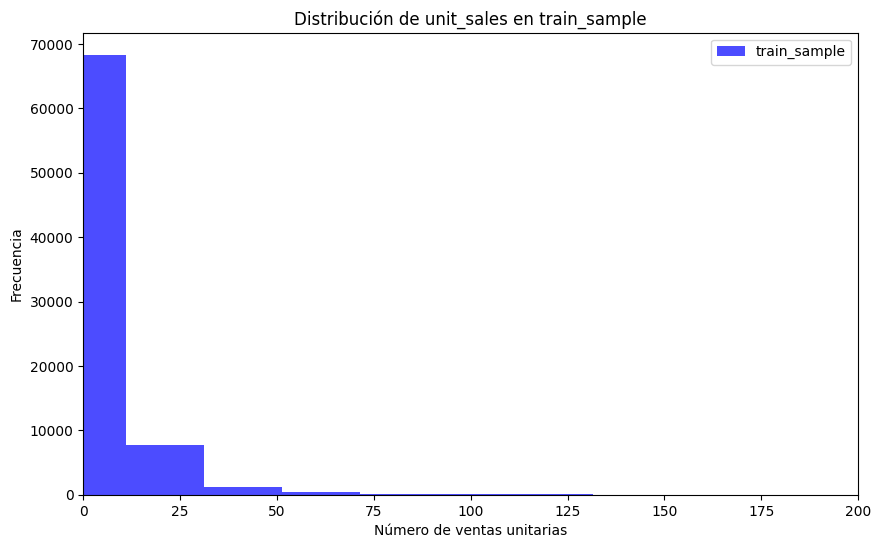

In [26]:
# Visualizar la distribución de unit_sales en train_sample
plt.figure(figsize=(10, 6))
plt.hist(train_sample['unit_sales'], bins=50, color='blue', alpha=0.7, label='train_sample')
plt.title('Distribución de unit_sales en train_sample')
plt.xlabel('Número de ventas unitarias')
plt.ylabel('Frecuencia')

plt.xlim(0, 200)

plt.legend()
plt.show()

Distribución de las ventas unitarias del train_store_state 📊

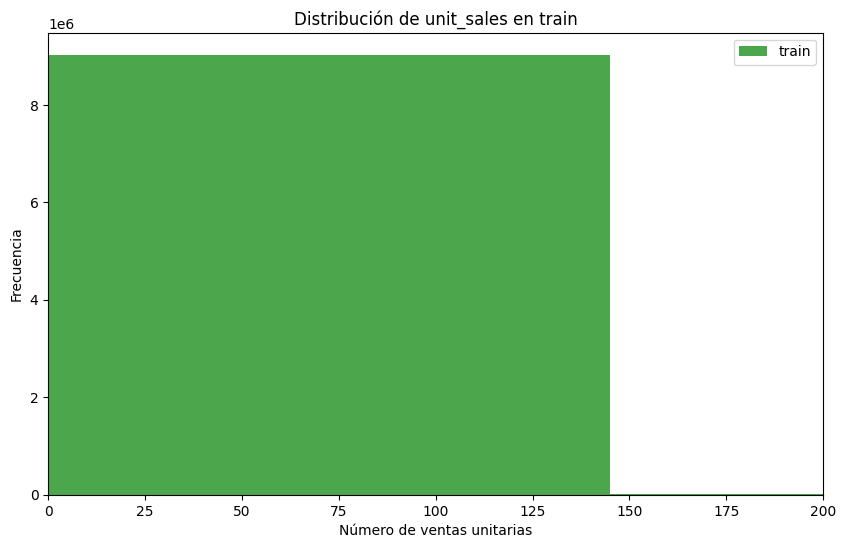

In [27]:
# Visualizar la distribución de unit_sales en train
plt.figure(figsize=(10, 6))
plt.hist(train_store_state['unit_sales'], bins=50, color='green', alpha=0.7, label='train')
plt.title('Distribución de unit_sales en train')
plt.xlabel('Número de ventas unitarias')
plt.ylabel('Frecuencia')

plt.xlim(0, 200)
plt.legend()
plt.show()

## **🔎Utilizando algunos modelos para hacer las primeras predicciones**

Los pesos, $w_i$, se pueden encontrar en el archivo items.csv (consultar la página de Datos). Los artículos perecederos tienen un peso de 1.25, mientras que todos los demás artículos tienen un peso de 1.00.

In [28]:
# Convertir las claves en train_store_state a cadenas
train_store_state['item_nbr'] = train_store_state['item_nbr'].astype(str)

# Asegurarse de que las claves en items sean cadenas
items.index = items.index.astype(str)

# Verificar las claves comunes
common_keys = set(train_store_state['item_nbr']).intersection(set(items.index))
print("Common Keys:", common_keys)

# Crear el diccionario de pesos ahora
weights_dict = {item_nbr: 1.25 if perishable == 1 else 1.00 for item_nbr, perishable in zip(train_store_state['item_nbr'], items['perishable'])}

Common Keys: set()


Quiero utilizar la métrica de evaluación para saber cual es el rendimiento de los diferentes modelos que estoy probando.

In [29]:
def calculate_nwrmsle(y_test, y_pred, weights, train_sample):
    n = len(y_test)
    squared_log_diff = np.log1p(y_test) - np.log1p(y_pred)
    squared_log_diff = squared_log_diff ** 2

    # Convertir squared_log_diff a un diccionario
    squared_log_diff_dict = dict(zip(train_sample['item_nbr'], squared_log_diff))

    # Convertir weights a un diccionario
    weights_dict = dict(weights)

    # Utilizar las claves del diccionario weights
    weighted_squared_log_diff = [squared_log_diff_dict.get(str(item_nbr), 0.0) * weights_dict.get(str(item_nbr), 1.0) for item_nbr in train_sample['item_nbr']]

    nwrmsle = np.sqrt(np.sum(weighted_squared_log_diff) / n)
    return nwrmsle

Función que evalua el rendimiento utilizando los estadisticos (MAE, MSE) tanto para los datos de entrenamiento como para los de prueba

In [30]:
# Definiendo una función para evaluar el rendimiento de cada modelo a utilizar
def checkModelPerformance(model, weights=None):
  # Entrenar el modelo con los datos de entrenamiento
  model.fit(X_train.values, y_train.values)

  # Realizar predicciones en el conjunto de entrenamiento
  train_predictions = model.predict(X_train.values)

  # Calcular y mostrar el error cuadrático medio (MSE) de las predicciones en el conjunto de entrenamiento
  train_mse = mean_squared_error(y_train.values, train_predictions)
  print("Train Mean Squared Error (MSE): ", train_mse)

  # Calcular y mostrar el error absoluto medio (MAE) de las predicciones en el conjunto de entrenamiento
  train_mae = mean_absolute_error(y_train.values, train_predictions)
  print("Train Mean Absolute Error (MAE): ", train_mae)

  # Realizar predicciones en el conjunto de prueba
  test_predictions = model.predict(X_test.values)

  # Calcular y mostrar el error cuadrático medio (MSE) de las predicciones en el conjunto de prueba
  test_mse = mean_squared_error(y_test.values, test_predictions)
  print("Test Mean Squared Error (MSE): ", test_mse)

  # Calcular y mostrar el error absoluto medio (MAE) de las predicciones en el conjunto de prueba
  test_mae = mean_absolute_error(y_test.values, test_predictions)
  print("Test Mean Absolute Error (MAE): ", test_mae)

  # Calcular y mostrar el nwrmsle
  if weights is not None:
    nwrmsle = calculate_nwrmsle(y_test.values, test_predictions, weights, train_sample)
    print("Test NWRMSLE: ", nwrmsle)

Entre menor sea el valor del estadistico de error [MAE], mejor será el modelo.

In [31]:
print("LinearRegression")
checkModelPerformance(LinearRegression(),weights_dict)

LinearRegression
Train Mean Squared Error (MSE):  171.23375676187766
Train Mean Absolute Error (MAE):  5.485140867444853
Test Mean Squared Error (MSE):  1.1709885047897924e+20
Test Mean Absolute Error (MAE):  207656979.514016
Test NWRMSLE:  nan


<ipython-input-29-24e3d5dc13df>:3: RuntimeWarning: invalid value encountered in log1p
  squared_log_diff = np.log1p(y_test) - np.log1p(y_pred)


In [32]:
print("ElasticNet")
checkModelPerformance(ElasticNet(),weights_dict)

ElasticNet
Train Mean Squared Error (MSE):  179.22579953735274
Train Mean Absolute Error (MAE):  5.508509555065091
Test Mean Squared Error (MSE):  176.0717574844881
Test Mean Absolute Error (MAE):  5.479703453054681
Test NWRMSLE:  2.7510941675389295


In [22]:
print("Ridge")
checkModelPerformance(Ridge(),weights_dict)

Ridge
Train Mean Squared Error (MSE):  171.32580456309927
Train Mean Absolute Error (MAE):  5.480453778097469
Test Mean Squared Error (MSE):  185.44710283048812
Test Mean Absolute Error (MAE):  5.7381569249241045
Test NWRMSLE:  2.863855113504266


In [33]:
print("Lasso")
checkModelPerformance(Lasso(),weights_dict)

Lasso
Train Mean Squared Error (MSE):  179.22579953735274
Train Mean Absolute Error (MAE):  5.508509555065091
Test Mean Squared Error (MSE):  176.0717574844881
Test Mean Absolute Error (MAE):  5.479703453054681
Test NWRMSLE:  2.7510941675389295
